In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from adjustText import adjust_text

In [3]:
from bml_analysis_io import *
from bml_analysis_func import *
from bml_analysis_plot import *
from bml_model_list import bmol, bxtal, color_dict

In [4]:
from asaplib.plot import plot_styles

plot_styles.set_nice_font()

In [6]:
# read the acronyms
acronym_list = np.genfromtxt("bml_name_acronym.list", dtype=str)
# print(acronym_list)

acronym_dict = {}
for a in acronym_list:
    acronym_dict[a[0]] = a[1]
# print(acronym_dict)

## parse

In [7]:
prefix = "qm7b"
file_prefix = prefix + "/benchmark_" + prefix

In [8]:
by_model = parse(file_prefix + ".json.gz")

In [9]:
all_model_keys = list(by_model.keys())
print(all_model_keys)

['bmol_acsf_longrange_ext_krr', 'bmol_acsf_longrange_ext_rr', 'bmol_acsf_longrange_int_krr', 'bmol_acsf_longrange_int_rr', 'bmol_acsf_minimal_ext_krr', 'bmol_acsf_minimal_ext_rr', 'bmol_acsf_minimal_int_krr', 'bmol_acsf_minimal_int_rr', 'bmol_acsf_smart_ext_krr', 'bmol_acsf_smart_ext_rr', 'bmol_acsf_smart_int_krr', 'bmol_acsf_smart_int_rr', 'bmol_cm_eigenspectrum_krr', 'bmol_cm_eigenspectrum_rr', 'bmol_cm_sorted_l2_krr', 'bmol_cm_sorted_l2_rr', 'bmol_ecfp4_krr', 'bmol_ecfp4_rr', 'bmol_ecfp6_krr', 'bmol_ecfp6_rr', 'bmol_gylm_minimal_ext_krr', 'bmol_gylm_minimal_ext_rr', 'bmol_gylm_minimal_int_krr', 'bmol_gylm_minimal_int_rr', 'bmol_gylm_standard_ext_krr', 'bmol_gylm_standard_ext_rr', 'bmol_gylm_standard_int_krr', 'bmol_gylm_standard_int_rr', 'bmol_mbtr_ext_krr', 'bmol_mbtr_ext_rr', 'bmol_mbtr_int_krr', 'bmol_mbtr_int_rr', 'bmol_pdf_gylm_minimal_krr', 'bmol_pdf_gylm_minimal_rr', 'bmol_pdf_gylm_standard_krr', 'bmol_pdf_gylm_standard_rr', 'bmol_pdf_soap_minimal_krr', 'bmol_pdf_soap_minimal

In [10]:
train_fraction_keys = list(by_model[all_model_keys[0]].keys())
print(train_fraction_keys)
max_train_frac = train_fraction_keys[-1]

['21:7190', '43:7168', '86:7125', '173:7038', '346:6865', '692:6519', '1384:5827', '2769:4442', '5538:1673']


## LC

In [13]:
lc_by_model = {}
lc_by_model_train = {}
sc_name = "RMSE"

worst_error = 0.0
best_model_error = {}

for category, model_key in bmol.items():
    best_error = 10**20.0

    best_model = None
    for key_now in model_key:
        lc_by_model[key_now], lc_by_model_train[key_now], _ = get_learning_curve(
            by_model, model_key_now=key_now, sc_name=sc_name
        )

        if np.min(lc_by_model[key_now][:, 1]) < best_error:
            best_error, best_model = np.min(lc_by_model[key_now][:, 1]), key_now
        if lc_by_model[key_now][0, 1] > worst_error:
            worst_error = lc_by_model[key_now][0, 1]

    best_model_error[best_error] = {"category": category, "model": best_model}

In [14]:
lr_by_model = {}

for category, model_key in bmol.items():
    for key_now in model_key:
        lc_now = lc_by_model[key_now]
        lr_by_model[key_now] = -(np.log(lc_now[0, 1]) - np.log(lc_now[-1, 1])) / (
            np.log(lc_now[0, 0]) - np.log(lc_now[-1, 0])
        )

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


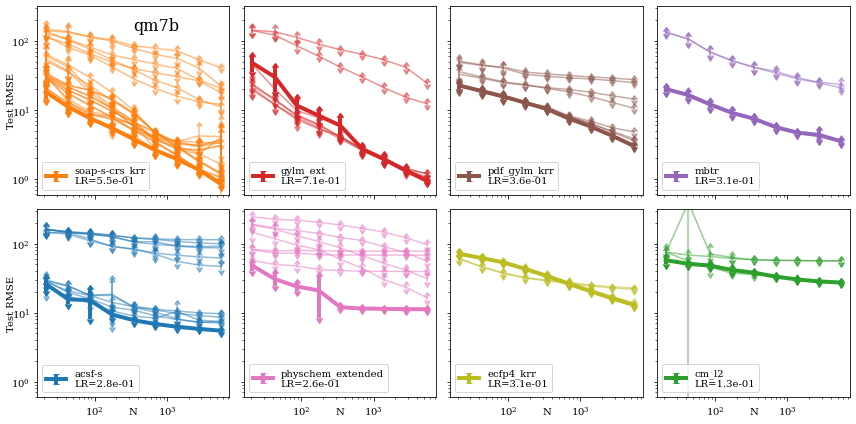

In [15]:
fig, ax = plt.subplots(
    nrows=len(bmol.items()) // 4, ncols=4, figsize=(12, 6), sharex=True, sharey=True
)

for i, [_, v] in enumerate(dict(sorted(best_model_error.items())).items()):

    category = v["category"]
    best_model = v["model"]

    for key_now in bmol[category]:
        ax[i // 4, i % 4].errorbar(
            lc_by_model[key_now][:, 0],
            lc_by_model[key_now][:, 1],
            yerr=lc_by_model[key_now][:, 2],
            linestyle="-",
            c=color_dict[category],
            alpha=0.5,
            uplims=True,
            lolims=True,
        )

    ax[i // 4, i % 4].errorbar(
        lc_by_model[best_model][:, 0],
        lc_by_model[best_model][:, 1],
        yerr=lc_by_model[best_model][:, 2],
        linestyle="-",
        linewidth=4,
        c=color_dict[category],
        alpha=1.0,
        label=acronym_dict[best_model] + "\n" + "LR=" + "{:.1e}".format(lr_by_model[best_model]),
        uplims=True,
        lolims=True,
    )

    ax[i // 4, i % 4].legend(loc="lower left")  # bbox_to_anchor=(1.3, 0.5))

for i in range(4):
    ax[1, i].set_xlabel("N", labelpad=-10)
for i in range(len(bmol.items()) // 4):
    ax[i, 0].set_ylabel("Test {}".format(sc_name), labelpad=-5)

ax[0, 0].set_ylim([best_error * 0.7, worst_error * 1.3])
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")

# To specify the number of ticks on both or any single axes
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=100))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

# ax.set_xticks([10, 20, 30, 40, 50])
# ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# ax.set_yticks([0.025, 0.05, 0.1, 0.2, 0.4])
# ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

ax[0, 0].text(
    0.5,
    0.9,
    prefix,
    fontsize=16,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax[0, 0].transAxes,
)

fig.tight_layout()

fig.savefig("benchmark_" + prefix + "-lc-seperate.pdf")

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


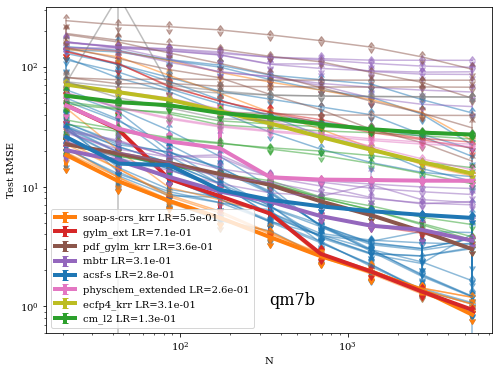

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))


for i, [_, v] in enumerate(dict(sorted(best_model_error.items())).items()):

    category = v["category"]
    best_model = v["model"]

    for key_now in bmol[category]:
        ax.errorbar(
            lc_by_model[key_now][:, 0],
            lc_by_model[key_now][:, 1],
            yerr=lc_by_model[key_now][:, 2],
            linestyle="-",
            c=cm.tab10(i),
            alpha=0.5,
            uplims=True,
            lolims=True,
        )

    ax.errorbar(
        lc_by_model[best_model][:, 0],
        lc_by_model[best_model][:, 1],
        yerr=lc_by_model[best_model][:, 2],
        linestyle="-",
        linewidth=4,
        c=color_dict[category],
        alpha=1.0,
        label=acronym_dict[best_model] + " LR=" + "{:.1e}".format(lr_by_model[best_model]),
        uplims=True,
        lolims=True,
    )

ax.legend(loc="best")  # bbox_to_anchor=(1.3, 0.5))
# ax.set_title('Learning curve for the dataset '+prefix)
ax.set_xlabel("N")
ax.set_ylabel("Test {}".format(sc_name))

ax.set_ylim([best_error * 0.7, worst_error * 1.3])
ax.set_xscale("log")
ax.set_yscale("log")

# To specify the number of ticks on both or any single axes
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=100))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

# ax.set_xticks([10, 20, 30, 40, 50])
# ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# ax.set_yticks([0.025, 0.05, 0.1, 0.2, 0.4])
# ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

ax.text(
    0.5,
    0.1,
    prefix,
    fontsize=16,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes,
)


fig.savefig("benchmark_" + prefix + "-lc.pdf")

In [13]:
test_RMSE = [[k, lc_by_model[k][-1, 1]] for k in by_model.keys()]
np.savetxt(prefix + "-test_RMSE.dat", test_RMSE, fmt="%s")

## model correlation matix

In [14]:
try:
    correlation_matrix = np.genfromtxt(prefix + "/" + prefix + "-model-y.kmat")
    model_list = np.genfromtxt(prefix + "/" + prefix + "-model-y.kmat", dtype="str")
except:
    correlation_matrix, model_list = model_correlation_matrix(
        by_model, max_train_frac, "test", "y", "SpearmanR", replica=None, verbose=True
    )
    np.savetxt(prefix + "/" + prefix + "-model-y.kmat", correlation_matrix, fmt="%.8e")
    np.savetxt(prefix + "/" + prefix + "-model-y.names", model_list, fmt="%s")

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


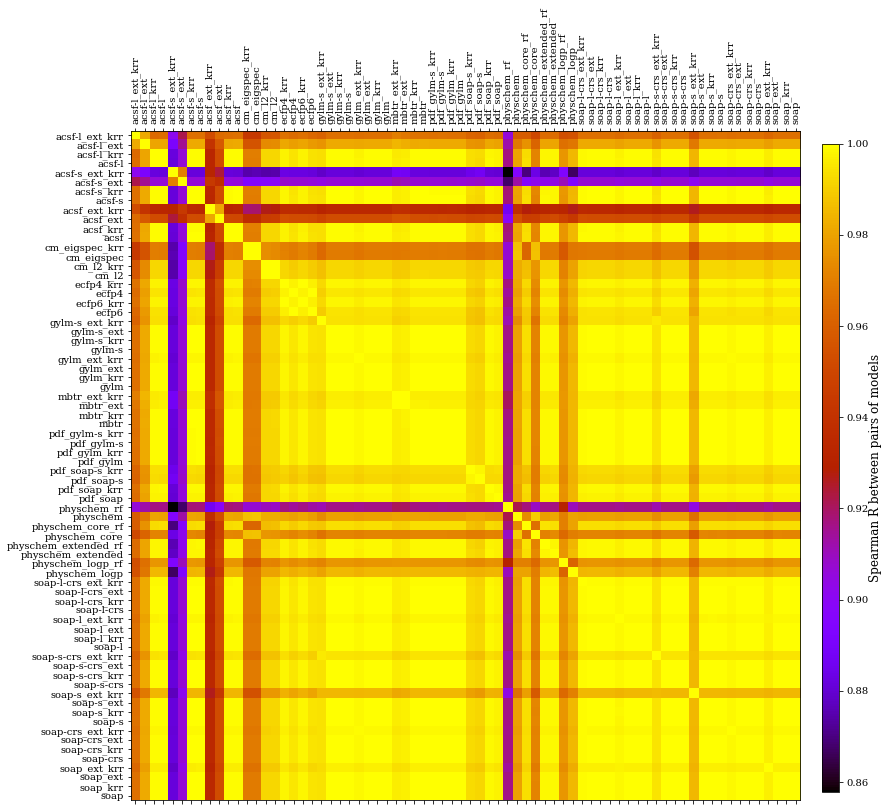

In [15]:
f = plt.figure(figsize=(12, 12))
pmat = plt.matshow(correlation_matrix, fignum=f.number, cmap="gnuplot")

annotate = list([acronym_dict[x] for x in by_model.keys()])
plt.xticks(range(correlation_matrix.shape[1]), annotate, fontsize=10, rotation=90)
plt.yticks(range(correlation_matrix.shape[1]), annotate, fontsize=10)

cbaxes = f.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = f.colorbar(pmat, cax=cbaxes, orientation="vertical")
cbar.ax.set_ylabel("Spearman R between pairs of models", labelpad=0, fontsize=12)

# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# cb.set_label('Spearman R between pairs of models', fontsize=12)
# plt.title('Correlation Matrix', fontsize=16);
plt.tight_layout()
f.savefig(file_prefix + "-model-Rmatrix.pdf", bbox_inches="tight")

## KPCA this correlation matrix

In [16]:
from asaplib.reducedim import KernelPCA

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/umap_learn-0.4.3-py3.7.egg/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [17]:
proj = KernelPCA(10).fit_transform(np.clip((correlation_matrix), 0, 1))

# Visualizations

In [18]:
from asaplib.plot import Plotters

Using scatter plot ...
Using annotation plot ...


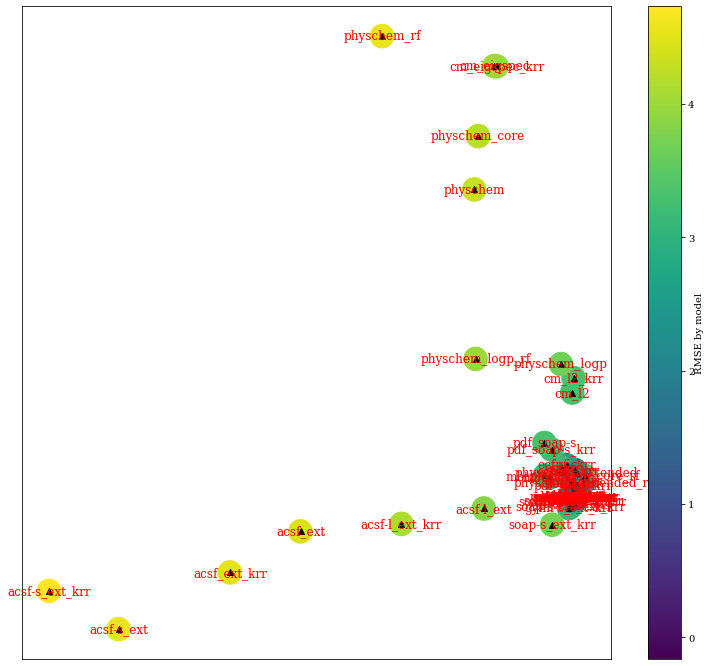

In [21]:
fig_spec = {
    "outfile": prefix + "-model-kpca.pdf",
    "show": False,
    "title": None,
    "size": [12 * 1.1, 12],
    "xlabel": None,
    "ylabel": None,
    "xaxis": True,
    "yaxis": True,
    "remove_tick": True,
    "cmap": "viridis",
    "components": {
        "first_p": {"type": "scatter", "clabel": "RMSE by model", "vmin": None, "vmax": None},
        "second_p": {"type": "annotate", "adtext": False},
    },
}

asap_plot = Plotters(fig_spec)

plotcolor = [np.log(lc_by_model[k][-1, 1]) for k in by_model.keys()]
annotate = list([acronym_dict[x] for x in by_model.keys()])
asap_plot.plot(proj[:, [0, 1]], plotcolor, [], annotate)

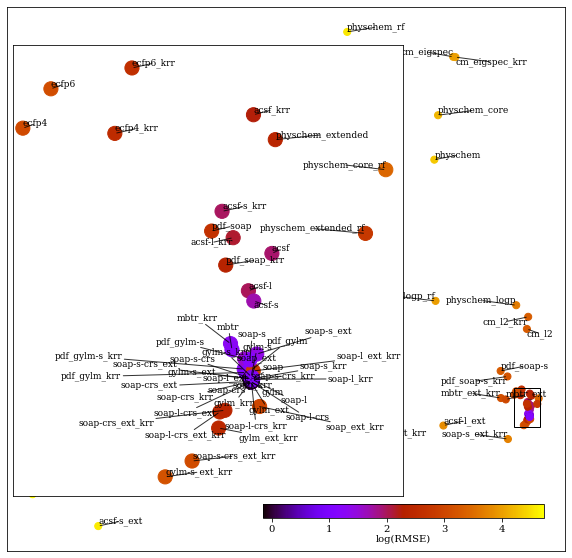

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

# project all
cset1 = ax.scatter(
    proj[:, 0], proj[:, 1], c=plotcolor[:], cmap=cm.get_cmap("gnuplot"), marker="o", s=50
)

cbaxes = fig.add_axes([0.48, 0.17, 0.39, 0.02])
cbar = fig.colorbar(cset1, cax=cbaxes, orientation="horizontal")
cbar.ax.set_xlabel("log(RMSE)", labelpad=0)

# the region to zoom in
zoomx = [0.018, 0.042]
zoomy = [-0.022, 0.000]
rect = patches.Rectangle((zoomx[0], zoomy[0]), zoomx[1] - zoomx[0], zoomy[1] - zoomy[0], fill=False)
ax.add_patch(rect)


# embed another subplot
subpos = [0.01, 0.1, 0.7, 0.83]
subax = plot_styles.add_subplot_axes(ax, subpos)

cset2 = subax.scatter(
    proj[:, 0], proj[:, 1], c=plotcolor[:], cmap=cm.get_cmap("gnuplot"), marker="o", s=200
)
subax.set_xlim(zoomx)
subax.set_ylim(zoomy)
subax.tick_params(direction="in", length=2, width=1, colors="black", grid_color="r", grid_alpha=0.5)
subax.tick_params(axis="y", direction="in", pad=-30)
subax.tick_params(axis="x", direction="in", pad=-10)


ax.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
ax.tick_params(
    axis="y",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    left=False,  # ticks along the bottom edge are off
    right=False,  # ticks along the top edge are off
    labelleft=False,
)  # labels along the bottom edge are off
subax.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
subax.tick_params(
    axis="y",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    left=False,  # ticks along the bottom edge are off
    right=False,  # ticks along the top edge are off
    labelleft=False,
)  # labels along the bottom edge are off


# annotate
texts = []
subtexts = []
for i, ano in enumerate(list([acronym_dict[x] for x in by_model.keys()])):
    if zoomx[0] < proj[i, 0] < zoomx[1] and zoomy[0] < proj[i, 1] < zoomy[1]:
        subtexts.append(
            subax.text(
                proj[i, 0], proj[i, 1], ano, ha="center", va="center", fontsize=9, color="black"
            )
        )
    else:
        texts.append(
            ax.text(
                proj[i, 0], proj[i, 1], ano, ha="center", va="center", fontsize=9, color="black"
            )
        )

adjust_text(
    texts,
    on_basemap=True,  # only_move={'points':'', 'text':'x'},
    expand_text=(1.01, 1.05),
    expand_points=(1.01, 1.05),
    force_text=(0.03, 0.1),
    force_points=(0.0, 0.0),
    ax=ax,
    precision=0.001,
    arrowprops=dict(arrowstyle="-", color="black", lw=1, alpha=0.8),
)

adjust_text(
    subtexts,
    on_basemap=True,  # only_move={'points':'', 'text':'x'},
    expand_text=(1.01, 1.05),
    expand_points=(1.01, 1.05),
    force_text=(0.03, 0.1),
    force_points=(0.0, 0.0),
    ax=subax,
    precision=0.001,
    arrowprops=dict(arrowstyle="-", color="black", lw=1, alpha=0.8),
)

fig.savefig(file_prefix + "-model-kpca.pdf", transparent=True)

# kernel matrix of descriptors

In [23]:
# note that we clip the min
desc_kmat = np.clip(np.loadtxt(prefix + "/" + prefix + "-descriptors-spearman.kmat"), 0, 1)
# desc_kmat = desc_kmat+np.ones(np.shape(desc_kmat))
desc_names = np.genfromtxt(prefix + "/" + prefix + "-descriptors.names", dtype="str")

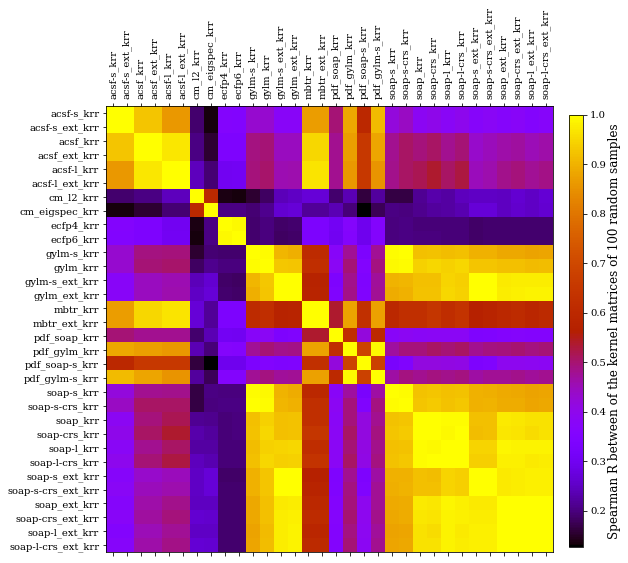

In [24]:
f = plt.figure(figsize=(10, 8))

pmat = plt.matshow(desc_kmat, fignum=f.number, cmap="gnuplot")

annotate = list([acronym_dict[x] for x in desc_names])
plt.xticks(range(desc_kmat.shape[1]), annotate, fontsize=10, rotation=90)
plt.yticks(range(desc_kmat.shape[1]), annotate, fontsize=10)

cbaxes = f.add_axes([0.87, 0.1, 0.02, 0.75])
cbar = f.colorbar(pmat, cax=cbaxes, orientation="vertical")
cbar.ax.set_ylabel(
    "Spearman R between of the kernel matrices of 100 random samples", labelpad=2, fontsize=12
)

f.savefig(file_prefix + "-kmat-Rmatrix.pdf", bbox_inches="tight")

In [25]:
proj = KernelPCA(10).fit_transform(np.clip((desc_kmat), 0, 1))

Using scatter plot ...
Using annotation plot ...


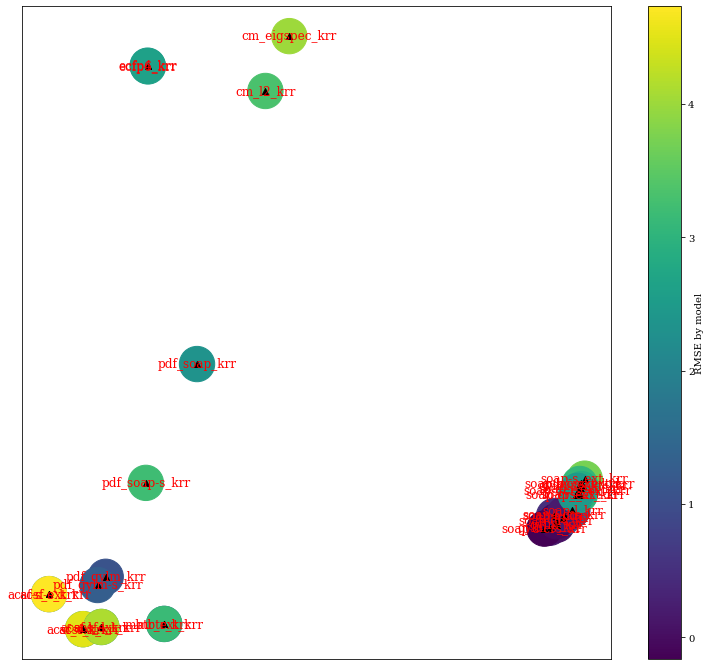

In [26]:
fig_spec = {
    "outfile": file_prefix + "-descriptor-similarity.pdf",
    "show": False,
    "title": None,
    "size": [12 * 1.1, 12],
    "xlabel": None,
    "ylabel": None,
    "xaxis": False,
    "yaxis": False,
    "remove_tick": True,
    "cmap": "viridis",
    "components": {
        "first_p": {"type": "scatter", "clabel": "RMSE by model", "vmin": None, "vmax": None},
        "second_p": {"type": "annotate", "adtext": False},
    },
}

asap_plot = Plotters(fig_spec)
plotcolor = [np.log(lc_by_model[k][-1, 1]) for k in desc_names]
annotate = list([acronym_dict[x] for x in desc_names])
# plotcolor = np.arange(len(proj))
asap_plot.plot(proj[:, [0, 1]], plotcolor, [], annotate)

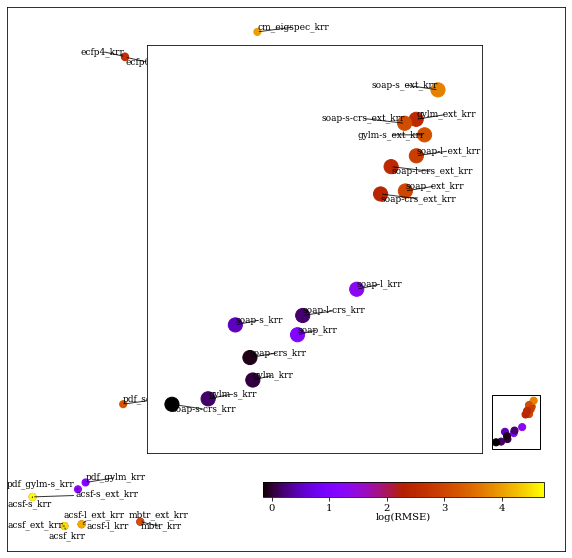

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

# project all
cset1 = ax.scatter(
    proj[:, 0], proj[:, 1], c=plotcolor[:], cmap=cm.get_cmap("gnuplot"), marker="o", s=50
)

cbaxes = fig.add_axes([0.48, 0.2, 0.39, 0.02])
cbar = fig.colorbar(cset1, cax=cbaxes, orientation="horizontal")
cbar.ax.set_xlabel("log(RMSE)", labelpad=0)

# the region to zoom in
zoomx = [0.37, 0.47]
zoomy = [-0.1, 0.01]
rect = patches.Rectangle((zoomx[0], zoomy[0]), zoomx[1] - zoomx[0], zoomy[1] - zoomy[0], fill=False)
ax.add_patch(rect)


# embed another subplot
subpos = [0.25, 0.18, 0.6, 0.75]
subax = plot_styles.add_subplot_axes(ax, subpos)

cset2 = subax.scatter(
    proj[:, 0], proj[:, 1], c=plotcolor[:], cmap=cm.get_cmap("gnuplot"), marker="o", s=200
)
subax.set_xlim(zoomx)
subax.set_ylim(zoomy)
subax.tick_params(direction="in", length=2, width=1, colors="black", grid_color="r", grid_alpha=0.5)
subax.tick_params(axis="y", direction="in", pad=-30)
subax.tick_params(axis="x", direction="in", pad=-10)


ax.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
ax.tick_params(
    axis="y",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    left=False,  # ticks along the bottom edge are off
    right=False,  # ticks along the top edge are off
    labelleft=False,
)  # labels along the bottom edge are off
subax.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
subax.tick_params(
    axis="y",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    left=False,  # ticks along the bottom edge are off
    right=False,  # ticks along the top edge are off
    labelleft=False,
)  # labels along the bottom edge are off

# annotate
texts = []
subtexts = []
for i, ano in enumerate(list([acronym_dict[x] for x in desc_names])):
    if zoomx[0] < proj[i, 0] < zoomx[1] and zoomy[0] < proj[i, 1] < zoomy[1]:
        subtexts.append(
            subax.text(
                proj[i, 0], proj[i, 1], ano, ha="center", va="center", fontsize=9, color="black"
            )
        )
    else:
        texts.append(
            ax.text(
                proj[i, 0], proj[i, 1], ano, ha="center", va="center", fontsize=9, color="black"
            )
        )

adjust_text(
    texts,
    on_basemap=True,  # only_move={'points':'', 'text':'x'},
    expand_text=(1.01, 1.05),
    expand_points=(1.01, 1.05),
    force_text=(0.03, 0.1),
    force_points=(0.0, 0.0),
    ax=ax,
    precision=0.001,
    arrowprops=dict(arrowstyle="-", color="black", lw=1, alpha=0.8),
)

adjust_text(
    subtexts,
    on_basemap=True,  # only_move={'points':'', 'text':'x'},
    expand_text=(1.01, 1.05),
    expand_points=(1.01, 1.05),
    force_text=(0.03, 0.1),
    force_points=(0.0, 0.0),
    ax=subax,
    precision=0.001,
    arrowprops=dict(arrowstyle="-", color="black", lw=1, alpha=0.8),
)

fig.savefig(file_prefix + "-kmat-kpca.pdf", transparent=True)